In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Classification with Boosted Tree Models

In [2]:
df = pd.read_csv("train2.csv")

In [3]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change_No,diabetesMed_Yes,readmitted
0,-1.137649,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,-3.321596,0.926591,-1.829868,0
1,1.877333,0.655900,0.387074,0.981622,-0.291461,-0.21262,-0.503276,0.815784,-1.079225,0.546488,1
2,1.542335,0.910040,1.559545,1.104660,-0.291461,-0.21262,-0.503276,0.815784,-1.079225,0.546488,0
3,2.212331,1.265834,-0.785398,1.104660,-0.291461,-0.21262,-0.503276,0.815784,-1.079225,0.546488,1
4,0.537341,0.198450,0.387074,-0.371804,-0.291461,-0.21262,-0.503276,0.298612,0.926591,-1.829868,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   time_in_hospital    101766 non-null  float64
 1   num_lab_procedures  101766 non-null  float64
 2   num_procedures      101766 non-null  float64
 3   num_medications     101766 non-null  float64
 4   number_outpatient   101766 non-null  float64
 5   number_emergency    101766 non-null  float64
 6   number_inpatient    101766 non-null  float64
 7   number_diagnoses    101766 non-null  float64
 8   change_No           101766 non-null  float64
 9   diabetesMed_Yes     101766 non-null  float64
 10  readmitted          101766 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 8.5 MB


In [5]:
df.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change_No,diabetesMed_Yes,readmitted
count,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,1.017660e+05,101766.000000
mean,-1.016295e-14,-3.161646e-14,-5.187778e-14,6.766087e-14,6.485384e-14,2.175072e-14,-3.191962e-14,2.581804e-14,9.551232e-15,-1.823700e-14,0.460881
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,0.498470
min,-1.137649e+00,-2.139630e+00,-7.853977e-01,-1.848268e+00,-2.914615e-01,-2.126202e-01,-5.032762e-01,-3.321596e+00,-1.079225e+00,-1.829868e+00,0.000000
25%,-8.026506e-01,-6.147950e-01,-7.853977e-01,-7.409197e-01,-2.914615e-01,-2.126202e-01,-5.032762e-01,-7.357332e-01,-1.079225e+00,5.464875e-01,0.000000
50%,-1.326548e-01,4.596660e-02,-1.991621e-01,-1.257264e-01,-2.914615e-01,-2.126202e-01,-5.032762e-01,2.986119e-01,9.265905e-01,5.464875e-01,0.000000
75%,5.373411e-01,7.067282e-01,3.870736e-01,4.894670e-01,-2.914615e-01,-2.126202e-01,2.885790e-01,8.157845e-01,9.265905e-01,5.464875e-01,1.000000
max,3.217324e+00,4.518815e+00,2.732016e+00,7.994826e+00,3.285094e+01,8.146673e+01,1.612568e+01,4.435992e+00,9.265905e-01,5.464875e-01,1.000000


In [6]:
df.shape

(101766, 11)

### Train Model

In [7]:
X = df.iloc[:,0:10]
y = df.iloc[:,10]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [9]:
X_train.shape, X_test.shape

((61059, 10), (40707, 10))

In [10]:
hist = HistGradientBoostingClassifier(random_state=0, max_iter=100, scoring='auc-roc', loss='binary_crossentropy')

In [11]:
hist.fit(X_train,y_train)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='binary_crossentropy', max_bins=255,
                               max_depth=None, max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=0, scoring='auc-roc', tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [12]:
y_pred = hist.predict(X_test)

In [13]:
y_pred

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

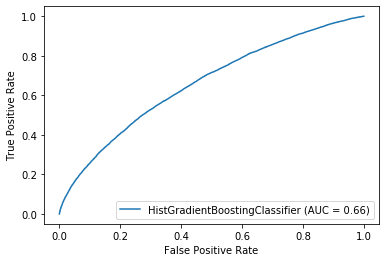

In [14]:
plot_roc_curve(hist,X_test,y_test)
plt.show()

### Create a Decision Forest Regression Model

In [15]:
df2 = pd.read_csv("train.csv")

In [16]:
df2

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,-1.356634,-1.005134,-1.610438,-1.670004,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.947372,-1.553889,-0.662755,-0.930189,16
1,-1.356634,-1.005134,-1.610438,-1.525374,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.561343,-0.804655,40
2,-1.356634,-1.005134,-1.610438,-1.380744,-0.172112,1.493891,-1.46690,-0.665193,-1.438516,-1.181732,0.895539,-1.553889,-0.622190,-0.837690,32
3,-1.356634,-1.005134,-1.610438,-1.236115,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.662755,-0.950010,13
4,-1.356634,-1.005134,-1.610438,-1.091485,-0.172112,1.493891,-1.46690,-0.665193,-1.334648,-1.093281,0.636370,-1.553889,-0.723603,-1.009474,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,-1.356634,0.994892,1.588467,1.077962,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.500495,-0.302517,119
17375,-1.356634,0.994892,1.588467,1.222591,-0.172112,-0.998987,0.68171,0.898924,-1.230779,-1.269602,-0.141137,-0.211691,-0.561343,-0.480908,89
17376,-1.356634,0.994892,1.588467,1.367221,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.269602,-0.141137,-0.211691,-0.581625,-0.467694,90
17377,-1.356634,0.994892,1.588467,1.511851,-0.172112,-0.998987,0.68171,-0.665193,-1.230779,-1.181732,-0.348473,-0.456099,-0.459930,-0.698942,61


In [18]:
X = df2.iloc[:,0:14]
y = df2.iloc[:,14]

In [19]:
X.values, y.values

(array([[-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.66275506, -0.93018925],
        [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.56134262, -0.80465484],
        [-1.3566343 , -1.0051343 , -1.61043792, ..., -1.55388851,
         -0.62219008, -0.83769021],
        ...,
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.21169121,
         -0.58162511, -0.46769408],
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
         -0.45993017, -0.69894166],
        [-1.3566343 ,  0.99489192,  1.58846698, ..., -0.45609864,
         -0.48021266, -0.77161947]]),
 array([16, 40, 32, ..., 90, 61, 49], dtype=int64))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [21]:
X_train.shape, X_test.shape

((12165, 14), (5214, 14))

In [22]:
hist = HistGradientBoostingRegressor(random_state=0, max_iter=100, scoring='rmse', loss='least_squares')

In [23]:
hist.fit(X_train,y_train)

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=0, scoring='rmse', tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [24]:
y_pred = hist.predict(X_test)

In [25]:
y_pred

array([  8.02600074,   4.88458622, 739.1829481 , ..., 503.40812932,
       302.87579958, 227.33938556])

In [26]:
mse = mean_absolute_error(y_test,y_pred)
mse

1.9969975500397013

In [27]:
rmse = np.sqrt(mse)
rmse

1.4131516373127482